In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.linalg
from scipy.spatial import distance
from sklearn.decomposition import PCA
import math
from sklearn import preprocessing  # to normalise existing X
import random
from scipy.spatial.distance import pdist,squareform
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.manifold import Isomap
from sklearn.decomposition import KernelPCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn import mixture
from sklearn.manifold import TSNE, MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import LocallyLinearEmbedding, trustworthiness
from sklearn.preprocessing import StandardScaler

### Functions

In [5]:
from scipy.sparse import csgraph, csc_matrix
import scipy.sparse.linalg as LA
import collections
from sklearn.neighbors import kneighbors_graph, radius_neighbors_graph
import scipy


def mds_reduction(data, target_dimension):
  return pd.DataFrame(MDS(n_components=target_dimension,eps=1e-4,n_init=15).fit_transform(data))
#PCA get principal components Functions
def get_pca(x):
    pca = PCA(n_components = d)
    pca.fit_transform(x)
    # print(pca.explained_variance_ratio_)
    return pca.explained_variance_ratio_, pca.components_
#Identifying Components with small Eigenvalue
THRESHOLD = 0.99
def find_normal_vectors(eigens, vectors):
  res = sum(eigens)
  current = 0
  normal_vectors = []
  for i in range(0,len(eigens)):
    current += eigens[i]
    if current/res > THRESHOLD:
      for j in range(i+1,len(eigens)):
        normal_vectors.append(vectors[j])
      break
  return normal_vectors
def normalized(X, c):
  for i in range(len(X)):
    X.iloc[i]-= c
  return preprocessing.normalize(X)
def variance(data):
  mean = sum(data) / len(data)
  deviations = [(x - mean) ** 2 for x in data]
  variance = sum(deviations) / len(data)
  return variance
def get_reduced(X, target_dimension, reduction_type):
  X_transformed = []
  if reduction_type == 'iso':
    embedding = Isomap(n_components=target_dimension, n_neighbors=10)
    X_transformed = embedding.fit_transform(X)
  elif reduction_type == 'pca':
    transformer = PCA(n_components=target_dimension)
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'k-pca':
    transformer = KernelPCA(n_components=target_dimension, kernel='rbf')
    X_transformed = transformer.fit_transform(X)
  elif reduction_type == 'tsne':
    X_transformed = TSNE(n_components=target_dimension, learning_rate='auto', init='pca').fit_transform(X)
  elif reduction_type == 'mds':
    X_transformed = mds_reduction(X,target_dimension)
  elif reduction_type == 'LLE':
    X_transformed = LocallyLinearEmbedding(n_components=target_dimension, n_neighbors=30).fit_transform(X)
  return X_transformed
def get_cluster(X, num_cluster, cluster_type):
  if cluster_type == 'GMM':
    model = mixture.GaussianMixture(n_components=num_cluster, covariance_type='full', n_init=100)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'k-means':
    model=KMeans(n_clusters=num_cluster, n_init=10, max_iter=10000)
    model.fit(X)
    labels = model.predict(X)
  elif cluster_type == 'HS':
    model = AgglomerativeClustering(n_clusters=num_cluster, linkage='single')
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'H':
    model = AgglomerativeClustering(n_clusters=num_cluster)
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'spectral':
    model = SpectralClustering(assign_labels='discretize', n_clusters=num_cluster, random_state=77, n_init=1)
    model.fit(X)
    labels = model.labels_
  elif cluster_type == 'custom-scan':
    td = get_dim(X)
    res = pd.DataFrame(LocallyLinearEmbedding(
      n_components=td,
      n_neighbors=d // 2,
      max_iter=100000
    ).fit_transform(
      X
    ), columns=[i for i in range(td)])
    # visualize_4d(res)
    compo = ComponentScan(n_neighbor=50, step=50).fit(res)
    compo.predict()
    return compo.components_
  elif cluster_type == 'PCAH':
    tmp = pd.DataFrame(PCA(
      n_components=3,
    ).fit_transform(
      X
    ), columns=[i for i in range(3)])
    return get_cluster(tmp, num_cluster, 'GMM')
  elif cluster_type == 'custom':
    td = 2
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=d).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  elif cluster_type == 'custom3d':
    td = 3
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=d).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  elif cluster_type == 'custom50':
    td = 2
    p = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=2 * d).fit_transform(StandardScaler().fit_transform(X)), columns=[j for j in range(td)])
    return get_cluster(p, cluster_type='GMM', num_cluster=num_cluster)
  return labels
def show_distance_graph(X):
  neigh = NearestNeighbors(n_neighbors=2)
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors(X)
  # Plotting K-distance Graph
  distances = np.sort(distances, axis=0)
  distances = distances[:,1]
  print(distances[-700:])
  plt.figure(figsize=(10,5))
  plt.plot(distances)
  plt.title('K-distance Graph',fontsize=20)
  plt.xlabel('Data Points sorted by distance',fontsize=14)
  plt.ylabel('Epsilon',fontsize=14)
  plt.show()
  #Visualization in 4D
def visualize_4d(frame, hot=True):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.add_subplot(111, projection='3d')
  x = np.array(frame.iloc[:,0])
  if len(frame.columns) > 1:
    y = np.array(frame.iloc[:,1])
  if len(frame.columns) > 2:
    z = np.array(frame.iloc[:,2])
  if len(frame.columns) == 1:
    img = ax.scatter(x, x, s=2)
  if len(frame.columns) == 2:
    img = ax.scatter(x, y, s=2)
  elif len(frame.columns) == 3:
    img = ax.scatter(x, y, z, s=2)
  else:
    c = np.array(frame.iloc[:,3])
    if hot:
      img = ax.scatter(x, y, z, c=c, cmap=plt.hot(), s=2)
    else:
      img = ax.scatter(x, y, z, c=c, cmap='viridis', s=2)
  plt.show()
def merge(X, col, val_list):
  def get_col(row):
    for ind in range(len(val_list)):
      if row[col] in val_list[ind]:
        return 100 + ind
    return row[col]
  X[col] = X.apply(get_col, axis=1)
  X[col] = LabelEncoder().fit_transform(X[col])
  X[col] -= 1
  return X
def get_local_intrinsic_dimension(data, n_neighbors=5):
  X = np.array(data)
  M = np.matrix(X)
  L = n_neighbors
  if not isinstance(L, (int, np.integer))  or L<0:
    return 'n_neighbors must be a positive integer!'
  neigh = NearestNeighbors(n_neighbors=L)
  nbrs = neigh.fit(X)
  distances, indices = nbrs.kneighbors()
  mean = [np.mean([M[indices[i][j]] for j in range(L)],axis=0) for i in range(len(X))]
  #Calculating the local covariance matrix for each point
  C = [1/L * sum([np.dot( (M[indices[i][j],:]-mean[i]).transpose() , (M[indices[i][j],:]-mean[i]) ) for j in range(L)]) for i in range(len(X))]

  #Intrinsic Dimension Estimation
  THRESHOLD = 0.05
  intrinsic_dimension = [0] * len(X)

  E = [sorted(LA.eigsh(C[i])[0], reverse=True) for i in range(len(X))]
  for i in range(len(X)):
    eigen_list = E[i]
    d = len(eigen_list)
    first_eigenvalue= eigen_list[0]
    for j in range(1,d):
      if eigen_list[j]/first_eigenvalue < THRESHOLD:
        intrinsic_dimension[i]=j
        break
    if intrinsic_dimension[i]==0:
      intrinsic_dimension[i]=d
  return np.array(intrinsic_dimension)
def is_manifold(data, n_neighbors=5, error=0.05, is_calculated=False):
  #Assuming data is consisted of submanifolds with DIFFERENT dimensions OR is just consisted of one manifold
  if not is_calculated:
    ID = get_local_intrinsic_dimension(data, n_neighbors=n_neighbors)
  else:
    ID = data['local_dim'].to_numpy()
  total = len(ID)
  # n_manifolds = max(ID)
  counter = collections.Counter(ID)
  print(counter)
  dimension = counter.most_common(1)[0][0]
  accuracy = counter[dimension]/total
  if accuracy > 1-error:
    # print(f'Accuracy: {accuracy}. Data resides on a {dimension}-dimensional manifold!')
    return True,accuracy
  # print(f'Accuracy: {accuracy} -> Inconclusive!')
  return False,accuracy
def predict_n_clusters(data, method='eigengap', n_neighbors=5, plot=False):
  if method=='eigengap':
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(data)
    distances, neighbors = nbrs.kneighbors(data)
    row = []
    col = []
    val = []
    for i in range(len(data)):
      for j in neighbors[i]:
        row.append(i)
        col.append(j)
        val.append(1)
    mat = csc_matrix((np.array(val), (np.array(row), np.array(col))), shape=(len(data), len(data)))
    k, _, _ = eigengap_heuristic(mat, plot=plot)
    return k
  return 'Invalid Combination of algorithm and method'
def showSilouette(X, model_list, plot=True):
  silouette = [silhouette_score(X, model_list[i].fit_predict(X)) for i in range(len(model_list))]
  if plot:
    plt.figure(figsize=(20,20))
    plt.plot(range(2, len(model_list)+2),silouette,'gs-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Curve')
    plt.show()
  return silouette.index(max(silouette))+2
def getAffinityMatrix(coordinates, n_neighbors):
  A = kneighbors_graph(coordinates, n_neighbors=n_neighbors, mode='connectivity', include_self=False).toarray()
  for i in range(len(A)):
    for j in range(len(A[0])):
      if A[i][j] == 1:
        A[j][i] = 1
  return A
def eigengap_heuristic(A, plot = True):
    L = csgraph.laplacian(A, normed=True)
    # print(L)
    # n_components = A.shape[0]
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in
    # the euclidean norm of complex numbers.
    eigenvalues = scipy.linalg.eigh(L, eigvals_only=True)
    print(eigenvalues[:10])
    # eigenvalues = np.negative(eigenvalues[::-1])
    # eigenvalues, eigenvectors = LA.einp.negative(L)g(L)
    if plot:
        plt.title('Largest eigen values of input matrix')
        plt.scatter(np.arange(len(eigenvalues))[:10], eigenvalues[:10])
        plt.grid()

    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    max_gap = 0
    gap_pre_index = 0
    for i in range(1, 6):
        gap = np.abs(eigenvalues[i] / eigenvalues[i - 1])
        if gap > max_gap:
            max_gap = gap
            gap_pre_index = i

    return gap_pre_index
def predict_n_clusters(data, plot=False, **kwargs):
  return eigengap_heuristic(getAffinityMatrix(data, n_neighbors=15), plot)
class ComponentScan:

  def __init__(self, n_neighbor=50, step=50):
    self.neighbors = None
    self.points = None
    self.n_neighbor = n_neighbor
    self.step = step
    self.components_ = None

  def fit(self, X):
    self.neighbors = []
    for i in range(5):
      nbrs = NearestNeighbors(n_neighbors=self.n_neighbor + i * self.step, algorithm='brute').fit(X)
      self.neighbors.append(nbrs.kneighbors(X)[1])
    self.points = X.to_numpy()
    self.components_ = np.full((len(X)), -1)
    return self

  def predict(self):
    cnt = 0
    ind = 0
    c = -1
    rep = 0
    while True:
      while ind < len(self.points):
        if self.components_[ind] == -1:
          break
        ind += 1
      if ind == len(self.points):
        break
      stack = [ind]
      combo = []
      cnt = 0
      c += 1
      while len(stack) > 0:
        cnt += 1
        if cnt % 1000 == 0:
          print(f'{cnt} - {len(stack)}')
        v = stack.pop()
        self.components_[v] = c
        for u in self.neighbors[rep][v]:
          if self.components_[u] == -1:
            stack.append(u)
            combo.append(u)
            self.components_[u] = c
      if len(combo) < 100:
        rep += 1
        if rep == 5:
          rep = 0
        for c in combo:
          self.components_[c] = -1
      else:
        rep = 0
    return c + 1
def get_dim(X, threshold=0.95, print_scores=False):
  for td in range(1, 15):
    res = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=50, max_iter=10000).fit_transform(X),
                       columns=[i for i in range(td)])
    score = trustworthiness(X, res, n_neighbors=d)
    if print_scores:
      print(f'dim score {td}: {score}')
    if score >= threshold:
      return td
  return d

### Open Input

In [6]:
# Input
file = open('./R43.txt','r')
d,n,m,k,p = list(file.readline().split())
d,n,p,k = map(int, [d, n, p, k])
k_list = list(map(int,file.readline().split()))
ar=[]
for i in range(0,n):
  ar.append(list(map(float,file.readline().split())))
df= pd.DataFrame(ar)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
count,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,...,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000,83732.000000
mean,900.793973,27.168648,-0.136205,12.758157,28.076036,59.632216,-6.981060,23.216674,85.848005,44.444390,...,-57.496764,3.075474,43.393192,47.202271,30.155224,19.171794,41.976750,21.771674,84.254643,14.056604
std,552.972090,24.627435,22.745172,18.809216,20.632893,26.120597,27.123498,27.214087,32.092357,23.228691,...,42.475659,23.810814,24.358144,32.725718,27.393103,22.055959,28.814611,18.946450,34.108199,22.180713
min,-1266.120000,-94.550000,-137.240000,-98.180000,-97.810000,-107.650000,-131.340000,-110.140000,-114.640000,-86.630000,...,-187.660000,-103.530000,-105.130000,-138.580000,-114.280000,-109.920000,-99.850000,-93.430000,-114.850000,-109.690000
25%,479.090000,16.730000,-13.630000,4.090000,16.760000,50.220000,-19.140000,3.020000,66.270000,32.330000,...,-86.120000,-13.810000,25.820000,28.850000,12.797500,8.660000,23.940000,8.500000,63.460000,3.447500
50%,887.470000,24.500000,2.730000,11.360000,30.050000,62.980000,-6.210000,26.730000,84.430000,46.950000,...,-48.630000,-1.150000,45.380000,42.310000,27.770000,19.980000,39.470000,22.430000,86.430000,15.690000
75%,1367.420000,38.340000,11.070000,19.700000,37.012500,75.610000,6.410000,41.010000,110.202500,54.350000,...,-30.830000,14.062500,65.090000,71.160000,49.780000,31.360000,62.840000,35.180000,106.080000,27.350000
max,1971.350000,138.230000,110.750000,97.550000,107.180000,161.280000,119.280000,123.420000,181.690000,125.480000,...,154.710000,122.590000,117.210000,138.690000,126.030000,98.420000,136.020000,92.820000,178.640000,97.530000


[ 38.34206958  38.36590935  38.39835283  38.41663962  38.49517762
  38.4982584   38.55331244  38.59629516  38.60314365  38.67371717
  38.67639202  38.72456197  38.72485765  38.82401448  38.85240276
  38.89265612  38.92544027  38.93205106  38.97546279  39.03829786
  39.0406647   39.04300193  39.04300193  39.15225281  39.16314594
  39.23463393  39.27079831  39.33556279  39.39274299  39.3962752
  39.42861905  39.44536982  39.44536982  39.46098073  39.51240565
  39.56960829  39.61924785  39.63734476  39.65800676  39.75907569
  39.83832953  39.87348743  39.90150122  39.93116202  39.98838956
  40.08893488  40.11949651  40.20954737  40.21144738  40.28046176
  40.29842553  40.35789142  40.38734084  40.40243062  40.43800811
  40.51958169  40.5223099   40.75181836  40.76843141  40.80465782
  40.82308048  40.98005246  41.0954523   41.14917618  41.19705936
  41.2098629   41.32568935  41.33285739  41.37118925  41.41932037
  41.69336278  41.77648382  41.80818221  41.81857243  41.87969436
  41.940932

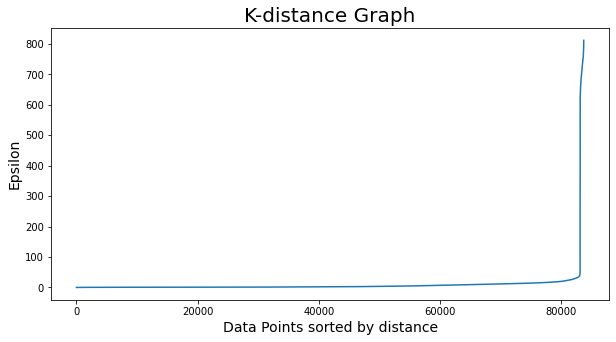

600


In [7]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df[[i for i in range(d)]])
show_distance_graph(df)
distances, indices = nbrs.kneighbors(df)
out = 0
for i in range(n):
  if distances[i][1] > 100:
    df.at[i, 'manifold'] = -1
    out += 1
print(out)

### Finding Submanifolds

In [8]:
def find_best_eps(min_sample):
  tmp = df[df['manifold'] != -1].copy()
  l, r = 0, 80
  while (r - l) > 1:
    mid = (r + l) / 2
    print(mid)
    model_name = 'dbscan'
    model = DBSCAN(eps=mid, min_samples=min_sample)
    model.fit(tmp[[i for i in range(d)]])
    tmp['subset'] = model.labels_
    print(f"count: {len(tmp[tmp['subset'] == -1])}")
    print(f"cluster count: {tmp['subset'].max() + 1}")
    if len(tmp[tmp['subset'] == -1]) > 0:
      l = mid
    else:
      r = mid
  return r

In [9]:
#DBSCAN
# best_eps = find_best_eps(5)
best_eps = 49.375
model = DBSCAN(eps=best_eps, min_samples=5)
model.fit(df[df['manifold'] != -1][[i for i in range(d)]])
df.loc[df['manifold'] != -1, 'manifold'] = model.labels_

In [10]:
%matplotlib inline
# multi = [0, 1, 4, 5, 14, 20, 32]
multi = []
if multi is None:
  multi = []
  for i in range(int(df['manifold'].max()) + 1):
    print(i)
    X = df[df['manifold'] == i][[i for i in range(d)]]
    if not is_manifold(X, n_neighbors=d // 2)[0] and not is_manifold(X, n_neighbors=3 * d // 2)[0]:
      multi.append(i)
      td = 3
      res = pd.DataFrame(LocallyLinearEmbedding(n_components=td, n_neighbors=20, max_iter=10000).fit_transform(X),
                           columns=[i for i in range(td)])
      visualize_4d(res)
      visualize_4d(X)


print(multi)

[]


In [11]:
%matplotlib inline
sp = df.copy()
# range(int(df.manifold.max()) + 1)
for subset in multi:
  print(f'processing subset {subset}')
  tmp = df[df['manifold'] == subset][[i for i in range(d)]]
  td = get_dim(tmp) or 6
  res = pd.DataFrame(LocallyLinearEmbedding(
    n_components=td,
    n_neighbors=d // 2,
    max_iter=100000
  ).fit_transform(
    tmp
  ), columns=[i for i in range(td)])
  # visualize_4d(res)
  k = ComponentScan(n_neighbor=50, step=50).fit(res).predict()
  print(f'manifold count: {k}')
  if k > 10:
    continue
  sp.loc[sp['manifold'] == subset, 'sub1'] = get_cluster(res, k, 'H')
  print(sp.loc[sp['manifold'] == subset, 'sub1'].value_counts())
  visualize_4d(pd.DataFrame(get_reduced(tmp, 3, 'pca'), columns=[j for j in range(3)]), hot=False)
if len(multi) > 0:
  sp['manifold'] = sp.manifold.astype(str) + '-' + sp.sub1.astype(str)
  sp = sp.drop(['sub1'], axis=1)
  sp['manifold'] = LabelEncoder().fit_transform(sp['manifold'])
  sp['manifold'] -= 1
  sp['manifold'].describe()

In [12]:
# custom cluster for manifold
final_k_list = []
cluster_type = []
for i in range(int(sp.manifold.max()) + 1):
  print(i)
  if i in [0, 6, 14]:
    cluster_type.append('PCAH')
    final_k_list.append(3)
    continue
  X = sp[sp['manifold'] == i][[j for j in range(d)]]
  td = get_dim(X) or 6
  res = pd.DataFrame(LocallyLinearEmbedding(
    n_components=td,
    n_neighbors=d // 2,
    max_iter=100000
  ).fit_transform(
    X
  ), columns=[i for i in range(td)])
  k = ComponentScan(n_neighbor=50, step=50).fit(res).predict()
  if k < 10:
    cluster_type.append('custom-scan')
  else:
    cluster_type.append('HS')
  final_k_list.append(k if k < 10 else 1)

0
1
1000 - 1428
2000 - 606
2
1000 - 1292
2000 - 296
3
1000 - 868
2000 - 606
4
1000 - 1221
2000 - 221
5
1000 - 448
6
7
1000 - 805
2000 - 794
8
1000 - 177
1000 - 580
9
1000 - 2308
2000 - 1308
3000 - 308
10
1000 - 985
2000 - 1308
3000 - 308
11
1000 - 116
2000 - 1054
3000 - 54
12
1000 - 2276
2000 - 1315
3000 - 317
13
1000 - 1821
2000 - 838
14
15
1000 - 1331
2000 - 335
16
1000 - 1744
2000 - 744
17
1000 - 1594
2000 - 965
18
1000 - 1592
2000 - 592
19
1000 - 30
20
1000 - 1224
2000 - 578
21
1000 - 993
2000 - 668
22
1000 - 123
23
1000 - 227
24
1000 - 1558
2000 - 574
25
1000 - 804
2000 - 557
26
1000 - 1659
2000 - 659
27
1000 - 1538
2000 - 552
28
1000 - 257
2000 - 353
29
1000 - 1971
2000 - 971
30
1000 - 889
2000 - 625
31
32
1000 - 752


In [13]:
%matplotlib notebook
df = sp
# final_k_list = [3, 1, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1]
print(final_k_list)
xsum = 0
for c in final_k_list:
  xsum += c
print(xsum)

[3, 1, 2, 1, 1, 2, 3, 1, 2, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1]
49


In [14]:
%matplotlib inline
def most_common_dimension(data, n_neighbors=5):
  ID = get_local_intrinsic_dimension(data, n_neighbors=n_neighbors)
  total = len(ID)
  # n_manifolds = max(ID)
  counter = collections.Counter(ID)
  dimension = counter.most_common(1)[0][0]
  return dimension,counter[dimension]/total
def estimate_intrinsic_dimension(data,n_neighbors=5, method='most_common'):
  res = 0
  if method=='most_common':
    return most_common_dimension(data,n_neighbors)[0]
  if method=='average':
    return np.around(np.mean(get_local_intrinsic_dimension(data),axis=0),0).astype(int)

plt.close('all')
D = []
for i in range(int(df.manifold.max()) + 1):
  print(i)
  X = df[df['manifold'] == 0][[j for j in range(d)]]
  dim1 = get_dim(X, print_scores=True)
  if dim1 < 6:
    D.append(dim1)
  else:
    D.append(estimate_intrinsic_dimension(X, n_neighbors=2 * d))
  print(D[-1])
print(D)
# [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

0
dim score 1: 0.7685023392370043
dim score 2: 0.9168118143995935
dim score 3: 0.9648055529089606
3
1
dim score 1: 0.7685031946164731
dim score 2: 0.9168109265552273
dim score 3: 0.9648054823330969
3
2
dim score 1: 0.7685043972291916
dim score 2: 0.9168117155933843
dim score 3: 0.9648052889552302
3
3
dim score 1: 0.7685043619412597
dim score 2: 0.9168125187467138
dim score 3: 0.9648043446501731
3
4
dim score 1: 0.7684999269539811
dim score 2: 0.916810442404802
dim score 3: 0.9648052748400574
3
5
dim score 1: 0.7685049166675488
dim score 2: 0.9168115095118621
dim score 3: 0.9648055529089606
3
6
dim score 1: 0.7685058369768123
dim score 2: 0.9168103534792137
dim score 3: 0.9648042684282402
3
7
dim score 1: 0.7685015177339501
dim score 2: 0.9168103506561791
dim score 3: 0.9648057533444138
3
8
dim score 1: 0.7685012975372553
dim score 2: 0.9168125187467138
dim score 3: 0.9648049120801178
3
9
dim score 1: 0.768511097701697
dim score 2: 0.9168105186267348
dim score 3: 0.9648083815895802
3
10

In [15]:
# Joining the cluster labeling
def join_clusters():
  df['cluster'] = [0]*n
  data_index = [0] * (int(df.manifold.max()) + 1)
  for i in range(n):
    index_manifold = int(df.at[i,'manifold'])
    if index_manifold!=-1:
      df.at[i,'cluster'] = list_labels[index_manifold][data_index[index_manifold]]
      data_index[index_manifold]+=1

list_labels = []
for i in range(int(df.manifold.max()) + 1):
  print(i)
  if final_k_list[i] == 1:
    list_labels.append([0] * len(df[df['manifold'] == i]))
    continue
  labels = get_cluster(df[df['manifold'] == i][[i for i in range(d)]], num_cluster=final_k_list[i], cluster_type=cluster_type[i])
  list_labels.append(labels)
print('------')
print(int(df.manifold.max()) + 1)
print('-------')
join_clusters()

0
1
2
1000 - 1292
2000 - 296
3
4
5
1000 - 448
6
7
8
1000 - 177
1000 - 580
9
10
11
12
13
14
15
1000 - 1331
2000 - 335
16
17
18
19
1000 - 30
20
21
22
23
24
25
26
27
1000 - 1538
2000 - 552
28
29
30
31
32
------
33
-------


### Output

In [16]:
import miniball

THRESHOLD = 0.99
def findNormalVectors(eigens,vectors):
  res = sum(eigens)
  current = 0
  normal_vectors = []
  for i in range(0,len(eigens)):
    current += eigens[i]
    if current/res > THRESHOLD:
      for j in range(i+1,len(eigens)):
        normal_vectors.append(vectors[j])
      break
  return normal_vectors
# Outputting
def get_affine_space(points):
  X = points
  s, v = get_pca(X)
  #Finding Normal Vectors using PCA
  A = findNormalVectors(s, v)
  #Finding b-s using PCA
  b = []
  mean = np.mean(points, axis = 0)
  for j in range(len(A)):
    b.append(np.dot(A[j],mean))
  return A, b
def getOptimalBall(points):
  points = np.asarray(points)
  minlist = [min(points, key=lambda p: p[j])[j] for j in range(0,d)]
  points = [[p[j]-minlist[j] for j in range(0,d)] for p in points]
  mb = miniball.Miniball(points)
  c = mb.center()
  for j in range(0,d):
    c[j]+=minlist[j]
  r = math.sqrt(mb.squared_radius())
  if not mb.is_valid():
    print('Possibly invalid!')
  print('Relative error', mb.relative_error())
  return c,r
def spherical_measure(data):
  X = np.array(data)
  n = len(X)
  d = len(X[0])
  c,r = getOptimalBall(X)
  c = np.array(c)
  r = np.array(r)
  SSE = np.array([(np.linalg.norm(X[i]-c)-r)**2 for i in range(n)]).sum()
  total = n * (r**2)
  print(SSE / total)
  return SSE/total
def get_manifold_type(data, acceptable_error=1e-3):
  X = data.to_numpy()
  mcl_d = estimate_intrinsic_dimension(X,d)
  pca_d = d-len(findNormalVectors(get_pca(X)[0], get_pca(X)[1]))
  if spherical_measure(data) < acceptable_error:
    print(f'{pca_d} - {mcl_d}')
    return 'Sphere'
  if pca_d > mcl_d:
    return 'Complex'
  return 'Affine'

vectors = [[[] for j in range(0,final_k_list[i])] for i in range(int(df.manifold.max()) + 1)]
#df.loc[df['column_name'] == some_value]
outlier = []
for i in range(n):
  if int(df.at[i, 'manifold']) == -1:
    outlier.append(i + 1)
  else:
    vectors[int(df.at[i, 'manifold'])][int(df.at[i, 'cluster'])].append(i + 1)

with open('./output.txt', 'w') as f:
  print(f'{n} {int(df.manifold.max()) + 1}', file=f)
  for i in range(int(df.manifold.max()) + 1):
    print(i)
    X = df[df['manifold'] == i][[j for j in range(d)]]
    manifold_type = get_manifold_type(X)
    if manifold_type == 'Complex':
      dimension = D[i]
    else:
      dimension = d - len(findNormalVectors(get_pca(X)[0], get_pca(X)[1]))
    print(f'{dimension} ' + str(final_k_list[i]) + f' {manifold_type}', file=f)
    if manifold_type != 'Complex':
      A, B = get_affine_space(X)
      for j in range(len(A)):
        print(' '.join(list(map(str,A[j]))), file=f)
      print(' '.join(list(map(str,B))), file=f)
    if manifold_type == 'Sphere':
      c, r = getOptimalBall(X)
      print(' '.join(list(map(str, c))) + ' ' + str(r), file=f)
    for j in range(0,final_k_list[i]):
      print(str(len(vectors[i][j])) + ' ' + ' '.join(list(map(str, vectors[i][j]))), file=f)
  print(str(len(outlier)) + ' ' + ' '.join(list(map(str, outlier))), file=f)



0
Relative error 1.2738133750155331e-15
0.05346663533637061
1
Relative error 6.666985422614167e-16
0.034079719671682177
2
Relative error 1.03761843468402e-15
2.5575119589249207e-05
13 - 6
Relative error 1.03761843468402e-15
3
Relative error 6.316160927560199e-16
0.04880373694049591
4
Relative error 1.1719151611463616e-15
0.021874941103887793
5
Relative error 6.296894741958706e-16
0.03458981978942263
6
Relative error 3.454701099836993e-16
0.04286437873208099
7
Relative error 5.595938050350367e-16
0.33025432299086455
8
Relative error 2.995932069539125e-16
0.1744886035236026
9
Relative error 7.805645178901585e-16
0.018721001164110233
10
Relative error 1.005452992451539e-15
0.031364227539769106
11
Relative error 7.680267836041271e-16
0.03409101625516323
12
Relative error 1.0718549242307896e-15
4.743205008037209e-05
17 - 6
Relative error 1.0718549242307896e-15
13
Relative error 2.013139461421669e-15
5.251905064894631e-05
17 - 6
Relative error 2.013139461421669e-15
14
Relative error 8.864252